# Imports

In [1]:
import numpy as np
from brainlit import registration as ardent # hue
from matplotlib import pyplot as plt
%matplotlib inline
from skimage.transform import resize, rescale

/home/dcrowley/env/lib/python3.6/site-packages/python_jsonschema_objects/__init__.py:53: UserWarning: Schema version http://json-schema.org/draft-04/schema not recognized. Some keywords and features may not be supported.
  self.schema["$schema"]
Using TensorFlow backend.


# Load data

In [2]:
template_file_path = 'assets/allen_mouse_brain_atlas.npy'
target_file_path = 'assets/cleared_mouse_brain.npy'

# Note: ardent.load wraps SimpleITK.ReadImage and functions for many file types.
# template = ardent.load(template_file_path)
# target = ardent.load(target_file_path)

template = np.load(template_file_path)
target = np.load(target_file_path)

template_resolution = np.array([100, 100, 100])
target_resolution = np.array([100, 100, 100])

In [3]:
template.shape, target.shape

((142, 90, 124), (132, 73, 111))

# Preprocess raw image

Process images before any resampling.

In [4]:
# Fix pure 0 background.
# Note: This is appropriate for tiled data with artificial 0-voxels where no data was actually collected.

# target[target == 0] = np.quantile(target[target != 0], 10**-target.ndim * 10)

# Downsample data

If the data is large enough that preprocessing at native resolution or repeated downsampling would be expensive, it can be downsampled here.

Note: The registration can be performed at multiple anisotropically specifiable scales, i.e. at any resolution(s) larger than what is given to the register method.

In [5]:
# Resample target to match template's resolution.
    # Note: It is not strictly necessary that the target matches the template's resolution. 
    #       The assumption here is that target was read in at much higher resolution.
    # Note: ardent.resample will produce a image of exactly the desired resolution.
    #       resize and rescale from skimage.transform are faster but are not guaranteed to exactly achieve a specified resolution.

new_target_resolution = np.copy(template_resolution)
target = ardent.resample(target, new_target_resolution, target_resolution)
# target = rescale(target, target_resolution / new_target_resolution)
target_resolution = new_target_resolution

In [6]:
template.shape, target.shape

((142, 90, 124), (132, 73, 111))

# Preprocess downsampled image

Process images after possible downsampling.

In [7]:
# Perform as needed.

# target = ardent.preprocessing.remove_grid_artifact(target, z_axis=2, sigma_blur=None, mask='Otsu')

# target = ardent.preprocessing.correct_bias_field(target, correct_at_scale=[50]*4)

In [8]:
# Note: It is important that the image be padded with background if the object being imaged touches the edge of the image.
#       Otherwise a streaking artifact may be introduced from problematic extrapolation.

template = ardent.basic_preprocessing_with_pad(template)
target   = ardent.basic_preprocessing_with_pad(target)

# Orient data

This assumes we are orienting the target's orientation to the template's.

##### Visualize data orientation as loaded. 

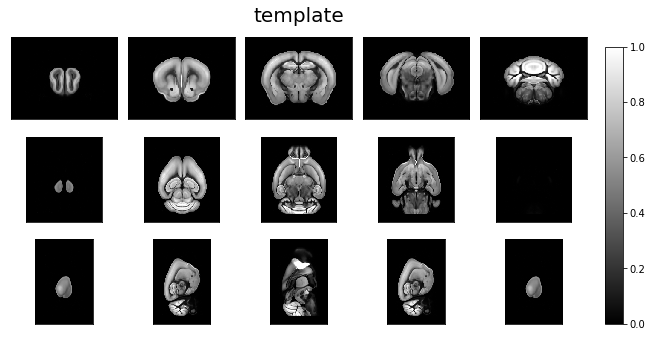

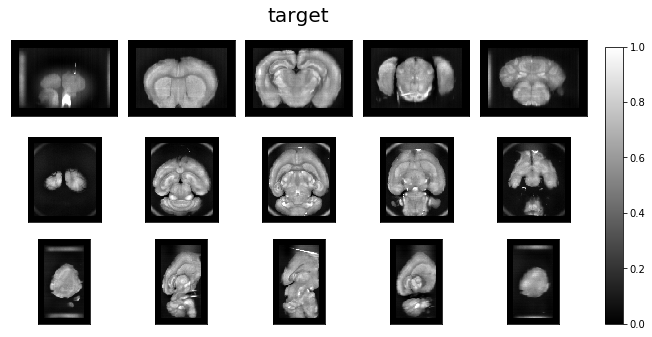

In [9]:
ardent.heatslices(template, 'template', limit_mode='quantile', quantile=0.001)
ardent.heatslices(target, 'target', limit_mode='quantile', quantile=0.001)

##### Reorient target and revisualize

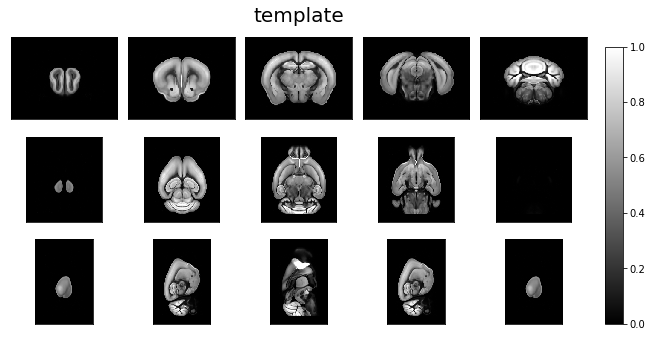

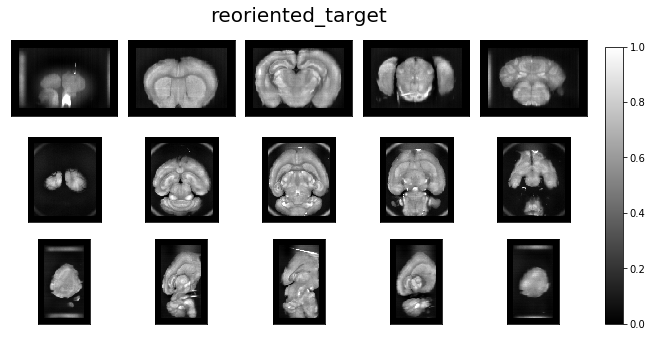

In [10]:
reoriented_target = np.copy(target)
reoriented_target_resolution = np.copy(target_resolution)

# Move axes.
destination = [0,1,2]
# destination = [0,2,1]
reoriented_target = np.moveaxis(reoriented_target, source=[0,1,2], destination=destination)
reoriented_target_resolution = reoriented_target_resolution[destination]

# Rotate.
k = 0 # How many rotations by 90 degrees.
axes = (1, 2) # Defines the plane of rotation.
reoriented_target = np.rot90(reoriented_target, k=k, axes=axes)
if k % 2:
    # Written for the 3D case, not the general case.
    if 0 not in axes:
        destination = [0, 2, 1]
    elif 1 not in axes:
        destination = [2, 1, 0]
    elif 2 not in axes:
        destination = [1, 0, 2]
    else:
        destination = [0, 1, 2]
    reoriented_target_resolution = reoriented_target_resolution[destination]

# Flip.
# axis = 0
# reoriented_target = np.flip(reoriented_target, axis=axis)

# If we performed an odd number of inversions with the above lines, 
# we must perform a flip to correct for inverting the image. 
# The simplest flip is a sagittal flip, since that is the axis of innate symmetry in the brain.

# reoriented_target = np.flip(reoriented_target, axis=2)

# Verify proper orientation.
ardent.heatslices(template, 'template', limit_mode='quantile', quantile=0.001)
ardent.heatslices(reoriented_target, 'reoriented_target', limit_mode='quantile', quantile=0.001)

##### Use reoriented target & target_resolution

In [11]:
# Once we've finished orienting target and corresponding resolution, we use the results as target and target_resolution.
target = reoriented_target
target_resolution = reoriented_target_resolution

# Parameter tune

This section exists for running parameter sweeps, i.e. attempting registrations with several values of a parameter, to find optimal values.

In [ ]:
%%capture tune_capture
%%time
# Note: Using capture magic allows the outputs of extended runs or series of runs to be preserved,
#       even if the connection to a remote server is interrupted.

# Note: The parameters specified here are not exhaustive of the options available. Further description is available in the docstring.

# Note: These 3 parameters are essential to provide.
#       It is necessary to provide deformative_stepsize and sigma_regularization for any not-strictly-affine registration.
#       It is essentially necessary to provide contrast_order as greater than 1 for any non-binary image.
deformative_stepsize = 3e2 # deformative_stepsize is resolution-dependent.
sigma_regularization = 2e1 # The smaller this value is, the harsher the constraint on deformation.
contrast_order = 3 # The default is 1, but 3 is generally appropriate for cross-modal histological images. 
# contrast_order is important to set if template and target are cross-modal.

affine_stepsize = 0.3

initial_affine = None
fixed_affine_scale = None # If specified, projects all affine updates to a rigid affine with this diagonal.
initial_velocity_fields = None 
# Note: there exist functions in ardent.preprocessing, 
#       locally_rotate_velocity_fields and locally_translate_velocity_fields, 
#       for creating non-identity initializations.

classify_and_weight_voxels = False
# Note: These priors are used if classify_and_weight_voxels is set to True.
artifact_prior = 0.2
background_prior = 0.01

spatially_varying_contrast_map = False
# Note: sigma_contrast is used if spatially_varying_contrast_map is set to True.
sigma_contrast = 5

# Note: This registration will run 50 rigid-affine-only iterations downsampled isotropically by 8,
#       then 50 (non-rigid) affine-only iterations and then 50 joint non-rigid affine and deformative iterations downsampled by 4,
#       then 200 joint non-rigid affine and deformative iterations downsampled by 2. 1 would be effectively not downsampled.
multiscales                 = 8, 4, 2
num_iterations              = 50, 100, 200
num_affine_only_iterations  = 50, 50, 0
num_rigid_affine_iterations = 50, 0, 0

# Speed run for quick iteration.
# multiscales                 = 8, 4
# num_iterations              = 50, 50
# num_affine_only_iterations  = 50, 0
# num_rigid_affine_iterations = 25, 0

# These are for diagnostic and progress tracking outputs.
calibrate = True # This generates a useful plot for analyzing the registration process.
track_progress_every_n = 10 # Setting this as positive is only useful if you are not %%capture-ing this cell's outputs.

# Convenience functions for iterataing over values at different scales.
logspace10 = lambda start, stop: np.logspace(start, stop, abs(stop - start) + 1)
logspace3 = lambda start, stop: np.logspace(start, stop, abs(stop - start) * 2 + 1)

show = True # This is not a parameter.
# for affine_stepsize in [0.2]:
# for sigma_regularization in logspace3(3, 1):
# for deformative_stepsize in logspace3(1, 3):
# for sigma_regularization in logspace10(5, -5):
for _ in [0]:
    print(
        f"affine_stepsize:      {affine_stepsize}\n"
        f"deformative_stepsize: {deformative_stepsize}\n"
        f"sigma_regularization: {sigma_regularization}\n"
    )
    
    # Note: If you would like to continue the previous registration where it left off, 
    #       Comment out the following 2 lines and uncomment the next line.
    #       Remember to switch back for a fresh registration.
    transform = ardent.Transform()
    try: transform.register(
#     try: transform.continue_registration(
        target              = target,
        template            = template,
        target_resolution   = target_resolution,
        template_resolution = template_resolution,

        multiscales = multiscales,
        preset      = None,

        affine_stepsize        = affine_stepsize,
#         deformative_stepsize   = eV * downsample_factor, # multiplying the value chosen for 100um by downsample_factor is a crude conversion.
        deformative_stepsize   = deformative_stepsize,
        sigma_regularization   = sigma_regularization,

        num_iterations              = num_iterations,
        num_affine_only_iterations  = num_affine_only_iterations,
        num_rigid_affine_iterations = num_rigid_affine_iterations,
        
        fixed_affine_scale = fixed_affine_scale,

        initial_affine          = initial_affine,
        initial_velocity_fields = initial_velocity_fields,

        contrast_order     = contrast_order,
        contrast_maxiter   = 5,
        sigma_contrast     = sigma_contrast,

        classify_and_weight_voxels     = classify_and_weight_voxels,
        sigma_matching                 = None,
        artifact_prior                 = artifact_prior,
        background_prior               = background_prior,
        spatially_varying_contrast_map = spatially_varying_contrast_map,
        calibrate                      = calibrate,
        track_progress_every_n         = track_progress_every_n,
    )
    except Exception as e: print('Exception occurred', e); # raise # Uncomment this raise if you want a series of registrations to stop on Exception
    else:
        if show:
            ardent.heatslices(transform.lddmm.contrast_deformed_template, title=f'contrast_deformed_template, sigma_contrast: {sigma_contrast:.2e}', limits=np.quantile(target, (0.01, 1 - 0.01)))
            ardent.heatslices(transform.lddmm.deformed_template, title=f'deformed_template, deformative_stepsize: {deformative_stepsize:.2e}', limit_mode='quantile', quantile=0.001)
            ardent.heatslices(target, title=f'target, affine_stepsize: {affine_stepsize:.2e}', limits=np.quantile(target, (0.01, 1 - 0.01)))
            ardent.heatslices(np.stack((transform.lddmm.contrast_deformed_template, resize(target, transform.lddmm.contrast_deformed_template.shape), transform.lddmm.contrast_deformed_template), -1), f'error in target space, sigma_regularization: {sigma_regularization:.2e}', limit_mode='quantile', quantile=0.001)


In [ ]:
# See the outputs of the above cell.

tune_capture.show()

# Perform registration

If you have appropriate parameters for your registration you may make use of this cleaner cell wherein you can directly specify exactly those parameters you require. All options are included with defaults specified in the docstring.

In [ ]:
%%capture registration_capture
%%time

# transform = ardent.Transform()

# transform.register(
#     # Images.
#     template,
#     target,
    
#     # Image resolutions.
#     template_resolution=template_resolution,
#     target_resolution=target_resolution,
    
#     # Multiscale.
#     multiscales=None,
    
#     # Preset.
#     preset=None,
    
#     # Iterations.
#     num_iterations=None,
#     num_affine_only_iterations=None,
#     num_rigid_affine_iterations=None,
    
#     # Stepsizes.
#     affine_stepsize=None,
#     deformative_stepsize=None, # --------------> Vital to set. Does depend on resolution.
    
#     # Affine specifiers.
#     fixed_affine_scale=None,
    
#     # Velocity field specifiers.
#     sigma_regularization=None, # --------------> Vital to set. Does not depend on resolution.
#     velocity_smooth_length=None,
#     preconditioner_velocity_smooth_length=None,
#     maximum_velocity_fields_update=None,
#     num_timesteps=None,
    
#     # Contrast map specifiers.
#     contrast_order=None, # --------------------> Vital to set if template and target are cross-modality. Recommendation: 3.
#     spatially_varying_contrast_map=None, # ----> Optional feature.
#     contrast_maxiter=None,
#     contrast_tolerance=None,
#     sigma_contrast=None,
#     contrast_smooth_length=None,
    
#     # Smoothness vs. accuracy tradeoff.
#     sigma_matching=None,
    
#     # Classification specifiers.
#     classify_and_weight_voxels=None, # --------> Optional feature.
#     sigma_artifact=None,
#     sigma_background=None,
#     artifact_prior=None,
#     background_prior=None,
    
#     # Initial values.
#     initial_affine=None,
#     initial_contrast_coefficients=None,
#     initial_velocity_fields=None,
    
#     # Diagnostic outputs.
#     calibrate=None,
#     track_progress_every_n=None,
# )

In [ ]:
# See the outputs of the above cell.

registration_capture.show()

# Apply registration

In [ ]:
# Apply registration to template and target.
    # Note: the registration can be reasonably applied to any image in the template or target space
    #       by substituting it for the corresponding image (template or target) as the subject kwarg in apply_lddmm.
    # Note: the registration can be applied at arbitrary resolution if specified with the output_resolution kwarg.
    #       If unspecified, it will default to the resolution of template or target, depending on deform_to.
        # Note: Applied at arbitrary resolution means resampling the underlying transformation and applying that, 
        #       different from applying the transformation as-is and resampling the result to the desired resolution.
    # Note: output_shape is specified so that the deformed images can be overlain directly with their undeformed counterparts.
    
deformed_target = transform.transform_image(
    subject=target, 
    subject_resolution=target_resolution, 
    output_shape=template.shape, 
    deform_to='template')

deformed_template = transform.transform_image(
    subject=template, 
    subject_resolution=template_resolution, 
    output_shape=target.shape, 
    deform_to='target')

# Visualize results

In [ ]:
# Overlay images.

# Note: If the intensities are different, it may be necessary to multiply or divide one of the images so that one doesn't dominate the other.

intensity_correction = 2

ardent.heatslices(np.stack([deformed_template, target * intensity_correction, deformed_template], -1), title='target space', limit_mode='quantile', quantile=0.001)
ardent.heatslices(np.stack([deformed_target, template / intensity_correction, deformed_target], -1), title='template space', limit_mode='quantile', quantile=0.001)

In [ ]:
# Define functions.

def scale_data(data, quantile_threshold=0.001):
    """Rescales data such that the central data points (ignoring the extrema) lie on the interval [0, 1]."""
    
    data = np.copy(data)
    
    lower_limit = np.quantile(data, min(quantile_threshold, 1 - quantile_threshold))
    upper_limit = np.quantile(data, max(quantile_threshold, 1 - quantile_threshold))
    data_range = upper_limit - lower_limit
    
    data -= lower_limit
    data /= data_range
    
    return data


def imshow_on_ax(axes, dim, column, image, overlaid_image=None, quantile_threshold=0.001):
    """
    Rescales image using scale_data and displays a central slice of it across the given dimension 
    on the specified element of <axes>.

    If an overlaid_image is provided, it is likewise rescaled and an RGB display is produced 
    using image as the Red and Blue channels and overlaid_image as the Green channel.
    """
    
    ax = axes[dim, column]
    ax.axis(False)
    
    scaled_image = scale_data(image, quantile_threshold)
    
    display_image = scaled_image
    
    if overlaid_image is not None:
        scaled_overlaid_image = scale_data(overlaid_image, quantile_threshold)
        display_image = np.stack([scaled_image, scaled_overlaid_image, scaled_image], axis=-1)
        
    ax.imshow(
        display_image.take(display_image.shape[dim] // 2, axis=dim), 
        cmap='gray', 
        vmin=0, 
        vmax=1, 
    )

# Make a sick visual.

# Column 0: raw template.
# Column 1: target deformed to template.
# Column 2: deformed_target overlaid with template.
# Column 3: deformed_template overlaid with target.
# Column 4: template deformed to target.
# Column 5: raw target.

fig, axes = plt.subplots(3, 6, figsize=(16,8))#, sharex=True, sharey=True)

fig.suptitle('Registration: Before & After')

# Call imshow for each subplot axes.
for dim in range(3):
    # vmin and vmax are set to saturate the top and bottom 0.1% extrema.
    
    # Column 0: raw template.
    imshow_on_ax(axes=axes, dim=dim, column=0, image=template)
    
    # Column 1: deformed_target.
    imshow_on_ax(axes=axes, dim=dim, column=1, image=deformed_target)
    
    # Column 2: deformed_target overlaid with template.
    imshow_on_ax(axes=axes, dim=dim, column=2, image=deformed_target, overlaid_image=template)

    # Column 3: deformed_template overlaid with target.
    imshow_on_ax(axes=axes, dim=dim, column=3, image=deformed_template, overlaid_image=target)

    # Column 4: deformed_template.
    imshow_on_ax(axes=axes, dim=dim, column=4, image=deformed_template)
    
    # Column 5: raw target.
    imshow_on_ax(axes=axes, dim=dim, column=5, image=target)
    

# Set column labels.
for ax, column_label in zip(axes[0], [
        'template', 
        'deformed_target', 
        'deformed_target \n& template overlay', 
        'deformed_template \n& target overlay', 
        'deformed_template', 
        'target', 
    ]):
    ax.set_title(column_label)
    

# Set row labels.
for ax, row_index in zip(axes[:, 0], range(len(axes))):
    row_label = f'Dimension {row_index}'
    ax.set_ylabel(row_label, rotation='vertical')